# Data Exploration

In [1]:
from setup import start_spark, extract_data

spark = start_spark(sesh_name = 'Jupyter Sktime Modelling')
train, val = extract_data(spark)
spark.stop()


In [2]:
train.head()

,total_rides,total_takings
pickup_date,,
2013-08-01,307272,4.567414e+06
2013-08-02,236761,3.534616e+06
2013-08-03,226554,3.182267e+06
2013-08-04,202310,3.073609e+06
2013-08-05,406487,6.657713e+06


## MLFlow Setup

In [3]:
import mlflow

In [4]:
mlflow.set_tracking_uri("http://192.168.64.21:5000/")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://192.168.64.21:5000/


The taxi_daily_forecast experiment has already been created

In [5]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.tbats import TBATS
import numpy as np

In [36]:
training_window=56
forecasting_horizon=7
step_size=7

In [37]:
cv = SlidingWindowSplitter(fh=forecasting_horizon, window_length=training_window, step_length=step_size)

In [7]:
# check the split points
cv.get_cutoffs(y=train['total_rides'])

array([ 55,  62,  69,  76,  83,  90,  97, 104, 111, 118, 125, 132, 139,
       146, 153, 160, 167, 174, 181, 188, 195, 202, 209, 216, 223, 230,
       237, 244, 251, 258, 265, 272, 279, 286, 293, 300, 307, 314, 321,
       328, 335, 342, 349, 356, 363, 370, 377, 384, 391, 398, 405, 412,
       419, 426, 433, 440, 447, 454, 461, 468, 475, 482, 489, 496, 503,
       510, 517, 524, 531, 538, 545, 552, 559, 566, 573, 580, 587, 594,
       601, 608, 615, 622, 629, 636, 643, 650, 657, 664, 671, 678, 685,
       692, 699, 706, 713, 720])

In [8]:
# check the number of splits
cv.get_n_splits(y=train['total_rides'])

96

## Fitting Models

In [9]:
from sktime.forecasting.model_evaluation import evaluate

In [38]:
seasonality=7

In [10]:
forecaster = AutoETS(auto=True, sp=seasonality, n_jobs=-1)
#forecaster = TBATS(
#     use_box_cox=False,
#     use_trend=False,
#     use_damped_trend=False,
#     sp=7,
#     use_arma_errors=False,
#     n_jobs=-1)

In [11]:
evaluation_results = evaluate(forecaster=forecaster, y=train['total_rides'].astype('float64'), 
         cv=cv, return_data=True)

/home/jovyan/.local/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/home/jovyan/.local/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr
/home/jovyan/.local/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/home/jovyan/.local/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr
/home/jovyan/.local/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/home/jovyan/.local/lib/python3.8/site-packages/sktim

In [12]:
evaluation_results.columns

Index(['test_MeanAbsolutePercentageError', 'fit_time', 'pred_time',
       'len_train_window', 'cutoff', 'y_train', 'y_test', 'y_pred'],
      dtype='object')

In [13]:
evaluation_results.head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.045080,1.186588,0.006808,56,2013-09-25,pickup_date 2013-08-01 307272.0 2013-08-02 ...,"pickup_date 2013-10-02 478552.0 Freq: D, Na...","2013-10-02 457454.559435 Freq: D, dtype: fl..."
1,0.023511,0.820490,0.003897,56,2013-10-02,pickup_date 2013-08-08 437214.0 2013-08-09 ...,"pickup_date 2013-10-09 488625.0 Freq: D, Na...","2013-10-09 500249.515991 Freq: D, dtype: fl..."
2,0.014290,0.514723,0.003836,56,2013-10-09,pickup_date 2013-08-15 473737.0 2013-08-16 ...,"pickup_date 2013-10-16 481692.0 Freq: D, Na...","2013-10-16 488624.790454 Freq: D, dtype: fl..."
3,0.041305,0.075667,0.003775,56,2013-10-16,pickup_date 2013-08-22 471540.0 2013-08-23 ...,"pickup_date 2013-10-23 502007.0 Freq: D, Na...","2013-10-23 481691.159945 Freq: D, dtype: fl..."
4,0.026393,0.073516,0.003196,56,2013-10-23,pickup_date 2013-08-29 456095.0 2013-08-30 ...,"pickup_date 2013-10-30 489569.0 Freq: D, Na...","2013-10-30 502662.835954 Freq: D, dtype: fl..."


tags = {"engineering": "ML Platform",
        "engineering_remote": "ML Platform"}
## Logging To MLflow

In [40]:
tags = {"package": "Sktime",
        "model": "sktime.forecasting.ets.AutoETS"}


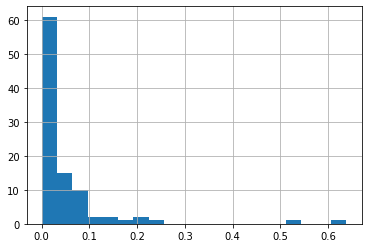

In [46]:
# lets log all the metrics from the sktime interval
with mlflow.start_run(experiment_id=15):
    mlflow.set_tags(tags)
    mlflow.log_param("training_window", training_window)
    mlflow.log_param("forecasting_horizon", forecasting_horizon)
    mlflow.log_param("step_size", step_size)
    mlflow.log_param("seasonality", seasonality)
    
    for item in evaluation_results.iterrows():
        #print('mape: {0}'.format(item[1][0]))
        mlflow.log_metric("mape", item[1][0], step=item[0])
        
    ax = evaluation_results.test_MeanAbsolutePercentageError.hist(bins=20)
    fig = ax.get_figure()
    fig.savefig('tmp/backtest_mape_hist.png')
    mlflow.log_artifact('tmp/backtest_mape_hist.png')
    

## Evaluating the results

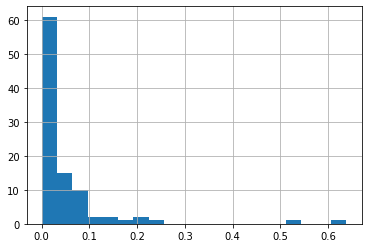

In [45]:
# histogram of fit loops
evaluation_results.test_MeanAbsolutePercentageError.hist(bins=20)

In [ ]:
fig = ax.get_figure()
fig.savefig('/path/to/figure.pdf')

# Testing Multiple Forecasters

In [ ]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.model_selection import ForecastingGridSearchCV

In [ ]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=7)),
        ("tbats", TBATS(use_box_cox=False, use_trend=False,
                     use_damped_trend=False, sp=7,
                     use_arma_errors=False, n_jobs=-1))
    ],
)

In [ ]:
forecaster_param_grid = {"selected_forecaster": ["ets", "naive", "tbats"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

In [ ]:
gscv.fit(train['total_rides'].astype('float64'))

In [ ]:
gscv.best_params_

## Testing TSFresh

TS Fresh needs to group windows of time together in order to generate the features that we need
So for a daily forecast leveraging tsfresh we should provide hourly or even more granular data then merge is up to daily features

In [ ]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [ ]:
tsfresh_train = pd.DataFrame({'idx': [1], 'values':[train['total_rides']]})

In [ ]:
t = TSFreshFeatureExtractor(show_warnings=False)
Xt = t.fit_transform(tsfresh_train) # train[['total_rides','total_takings']]
Xt.head()